In [2]:
import astropy
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits, ascii
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as un
import numpy as np
import pandas as pd

# import matplotlib
# import matplotlib.lines as lines
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedFormatter

# from plot_fqn import sbar_plotter, scale, beam, beam_plotter, difmap_model_read, info, load, open, cut, scale, difmap_model_read
import plot_fqn
import warnings
warnings.filterwarnings("ignore");

#### Functions (Most Recent)

In [3]:
def beam(hdu):
    beam_dict = {};
    beam_dict = {"b_major": hdu.header['BMAJ'], "b_minor": hdu.header['BMIN'], "b_pa": hdu.header['BPA']};
    #All units in degree
    
    return(beam_dict)


def info(hdu, in_center_dict=None):
    
    if (str(hdu.__class__) == "<class 'astropy.io.fits.hdu.image.PrimaryHDU'>"):
        
        info_dict = {};
        info_dict = { "obs_code": hdu.header['OBSERVER'], "obs_date": hdu.header['DATE-OBS'],
                 "obsra": hdu.header['OBSRA'], "obsdec": hdu.header['OBSDEC'],
                 "rms": hdu.header['NOISE'], "min": hdu.header['DATAMIN'], "max": hdu.header['DATAMAX']};
        center_dict = {};
        center_dict = {"centpxl_ra": hdu.header['CRPIX1'], "centpxl_dec": hdu.header['CRPIX2'],
                "center_ra": hdu.header['CRVAL1'], "center_dec": hdu.header['CRVAL2'],
                "scale_ra": hdu.header['CDELT1'], "scale_dec": hdu.header['CDELT2'],
                "npxl_ra": hdu.header['NAXIS1'], "npxl_dec": hdu.header['NAXIS2']};
        return(info_dict, center_dict);
        
    elif (str(hdu.__class__) == "<class 'astropy.io.fits.header.Header'>"):
        
        info_dict = {};
        info_dict = { "obs_date": hdu['DATE-OBS']};
        center_dict = in_center_dict;
        center_dict |= {"centpxl_ra": hdu['CRPIX1'], "centpxl_dec": hdu['CRPIX2'],
                "center_ra": hdu['CRVAL1'], "center_dec": hdu['CRVAL2'],
                "scale_ra": hdu['CDELT1'], "scale_dec": hdu['CDELT2']};
        return(info_dict, center_dict);
    else:
        print("Not work!",str(hdu.__class__));

def load(filename):
    hdu = fits.open(filename)[0];
    hdu_data = hdu.data[0][0];
    wcs_tmp = WCS(hdu.header);
    wcs_tmp1 = wcs_tmp.dropaxis(3);
    wcs = wcs_tmp1.dropaxis(2);
    
    return(hdu_data, wcs, hdu)

def open(filename):
    img_data, wcs, image = load(filename);
    
    img_info, center_data = info(image);
    beam_data = beam(image);
    
    allinone = (img_info | beam_data | center_data);
    return(img_data, wcs, image, allinone)

## Cutting function
def cut(data, in_wcs, hdu, center_dict, center_pos, box):
    
    size = un.Quantity(box, un.pix);
    
    cutout = Cutout2D(data, position=center_pos, size=size, wcs=in_wcs, copy=True);
    cutout_wcs = cutout.wcs.to_header();
    wcs_cut = WCS(cutout_wcs);
    cutout_data = cutout.data;
    
    center_tmp = cutout.center_cutout;
    center_coord = wcs_cut.pixel_to_world(center_tmp[0],[1]);
    _ , new_center_dict = info(cutout_wcs, center_dict);
    # new_center_dict = {'centpxl_ra': center_coord.ra.degree, 'centpxl_dec':center_coord.dec.degree,
    #                   'center_ra': center_tmp[0], 'center_dec': center_tmp[1]};
    new_center_dict |= {'centpxl_ra': center_tmp[0], 'centpxl_dec':center_tmp[1],
                      'center_ra':center_pos.ra.degree, 'center_dec':center_pos.dec.degree,
                       'npxl_ra': size[0].value, 'npxl_dec':size[1].value};
    
    return(cutout_data, wcs_cut, hdu, new_center_dict);

##    # ploting functions
def scale(hdu, beam_dict, size):
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (size/beamsize);
    width = (beam_dict['b_major']*sbar_scale);

    return(width);

def beam_plotter(beam_dict, center_dict, ax_name):
    
    ra_offset = (center_dict['npxl_ra']/2 - 25)*center_dict['scale_ra'];
    dec_offset = (center_dict['npxl_dec']/2 )*center_dict['scale_dec'];
   
    beam_ra = (center_dict['center_ra'] - ra_offset + beam_dict['b_major']/2); 
    beam_dec = (center_dict['center_dec'] - dec_offset + beam_dict['b_major']);
    
    beam = Ellipse((beam_ra, beam_dec), height=beam_dict['b_major'], width = beam_dict['b_minor'], 
                   angle=beam_dict['b_pa'], transform=ax_name.get_transform('fk5'), edgecolor='w',
                   facecolor='w', alpha=0.7, lw=2);
    return(beam);

def sbar_plotter(center_dict, beam_dict, sbar_width_ang, ax_name, finetune_ra=0, finetune_dec=0):
    
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (sbar_width_ang/beamsize);
    
    sbarwidth = (beam_dict['b_major']*sbar_scale);
    
    sbar_ra_offset = (center_dict['npxl_ra']/2 - 20);
    sbar_dec_offset = (center_dict['npxl_dec']/2 - 15);
    
    sbar_rad = (center_dict['center_ra'] + sbar_ra_offset*center_dict['scale_ra']);
    sbar_dec = (center_dict['center_dec'] - sbar_dec_offset*center_dict['scale_dec']);
    
    
    sbartxt = str(sbar_width_ang) + ' mas';
  
    sbar_ra_txt = (sbar_ra_offset - 5*sbar_width_ang+ finetune_ra);
    sbar_dec_txt = (sbar_dec_offset- 7 + finetune_dec);
    
    sbar_txt_rad = (center_dict['center_ra'] +
                    sbar_ra_txt*center_dict['scale_ra']);
    sbar_txt_dec = (center_dict['center_dec'] - sbar_dec_txt*center_dict['scale_dec']);

    sbar = Rectangle((sbar_rad, sbar_dec), width = sbarwidth, height = beam_dict['b_minor']/10,
                    transform=ax_name.get_transform('fk5'), color='w', facecolor='w', lw=2);
                     
    return(sbar, sbartxt, sbar_txt_rad, sbar_txt_dec);

def difmap_model_read(modelfit_file):

    header_names = ['Flux (Jy)', 'Flux (jy) Std', 'East (arcsec)', 'RA (arcsec) Std', 'North (arcsec)', 'Dec (arcsec) Std', 'Shape', 'R.A. (deg)', 'Dec (deg)',
        'Major FWHM (arcsec)', 'Major Std', 'Minor FWHM (arcsec)', 'Minor Std', 'Theta (deg)', 'Theta Std', 'Freq (Hz)', 'Spectral Index', 'Spec Indx Std' ];
    
    difmap_df = pd.read_csv(modelfit_file, header=None, sep=r'\s+', skiprows=[0,1,2], engine='python', names=header_names, skipinitialspace=True);
    # difmap_coords = 1;
    difmap_coords = SkyCoord(difmap_df.iloc[0,7], difmap_df.iloc[0,8], unit=(un.degree, un.degree),
                             obstime="J2000", frame='fk5');

    return(difmap_df, difmap_coords);


### Gaia Stuff

In [4]:
gaia_df = pd.read_csv('./tables/V1674HER_gaia.csv', delimiter=',');
v1674her_df = gaia_df.iloc[3];
v1674her_gaia = v1674her_df.to_dict();
#ra_pm = un.Quantity(v1674her_gaia['pmra'], unit=(un.mas/un.year));

gaia = SkyCoord(v1674her_gaia['ra'], v1674her_gaia['dec'], unit=(un.degree, un.degree), 
                obstime="J2016", pm_ra_cosdec=(v1674her_gaia['pmra']*(un.mas/un.year)), 
                pm_dec=(v1674her_gaia['pmdec']*(un.mas/un.year)));

ra_err = (v1674her_df['dec_error']*un.mas).to(un.degree).value;
dec_err = (v1674her_df['ra_error']*un.mas).to(un.degree).value;
rapm_err = (v1674her_df['pmra_error']*un.mas).to(un.degree).value;
decpm_err = (v1674her_df['pmdec_error']*un.mas).to(un.degree).value;

gaia_xerr = (ra_err**2+rapm_err**2)**(1/2);
gaia_yerr = (dec_err**2+rapm_err**2)**(1/2);



gaia_simbad = SkyCoord('284.37907767182', '+16.8943096496', unit=(un.deg), obstime="J2016");
gaia_simbad_fk5 = SkyCoord('18 57 30.9832440660', '+16 53 39.589542422', unit=(un.hourangle, un.degree), frame='fk5');

hi = gaia_simbad.separation(gaia).to(un.mas);
# print(v1674her_df)
gaia.dec.dms

dms_tuple(d=16.0, m=53.0, s=39.51473858212722)

### Difmap Model fit

In [5]:
modelfitb, modelfitb_coords = difmap_model_read('./imfit/modelfitB_1.txt');
modelfitd, modelfitd_coords = difmap_model_read('./imfit/modelfitd.txt');
modelfitf, modelfitf_coords = difmap_model_read('./imfit/modelfitF.txt');

## Images

### V1674HERB


#### data insert

In [6]:
imgb_data, wcsb, imageb = load("./V1674HERIMG/0130/V1674HERB_CLN.fits");

imgb_info, imgb_cnt = info(imageb);

beamb = beam(imageb);

cutb_data, cut_wcsb, cutb_hdu, cutb_center = cut(imgb_data, wcsb, imageb, imgb_cnt, center_pos=modelfitb_coords, box=(350,350));

shifted_gaia = gaia.apply_space_motion(new_obstime=astropy.time.Time(imgb_info['obs_date']));

# shifted_gaia = shifted_gaia_tmp;
# # .transform_to('fk5');
shifted_gaia = shifted_gaia.transform_to('fk5');

#### plots

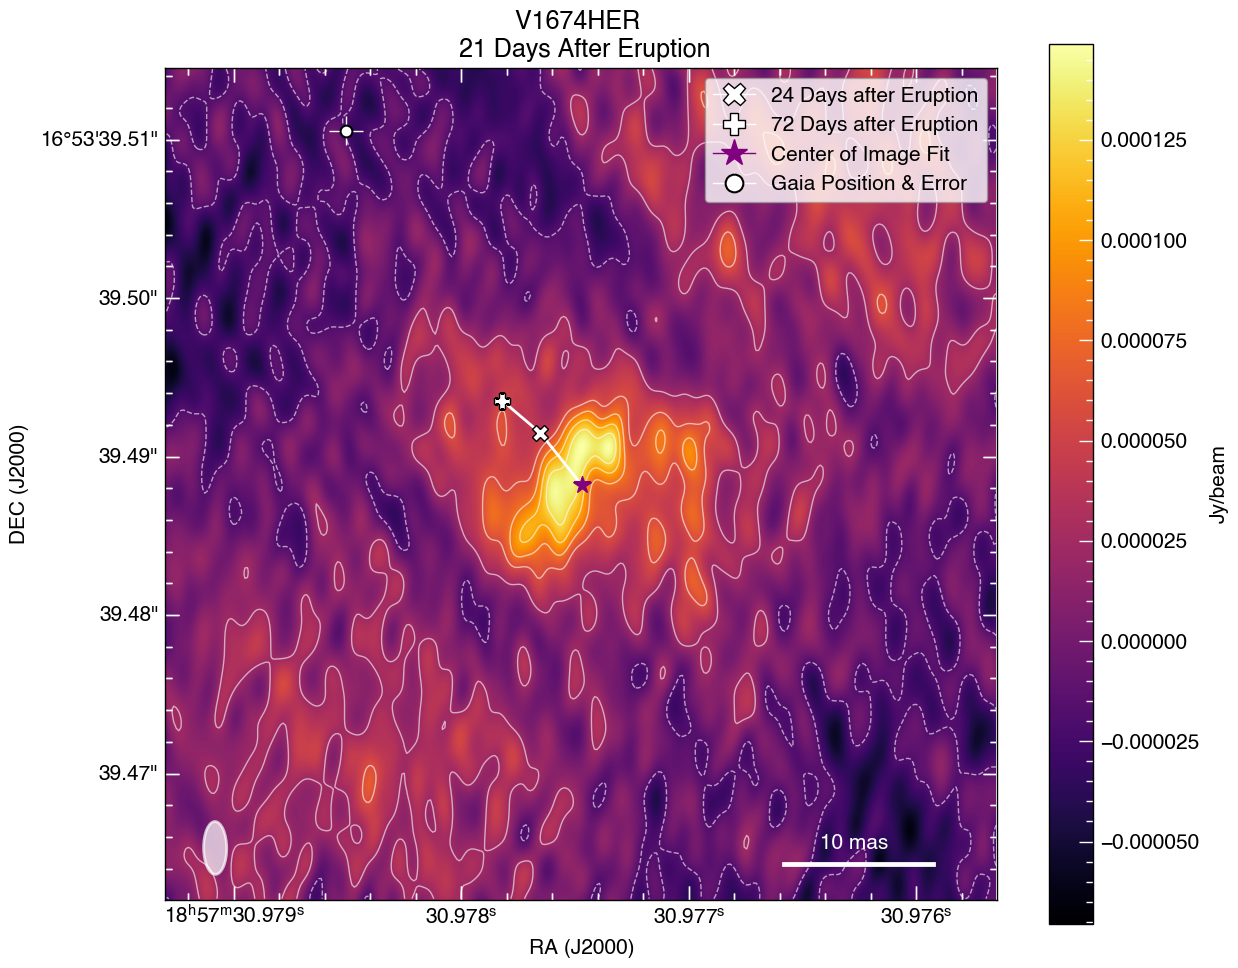

In [18]:
plt.style.use('light');

figb = plt.figure(figsize=(13,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_b = axb.coords[0];
dec_b = axb.coords[1];


axb.set_title(f'V1674HER \n 21 Days After Eruption');

imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutb_center, beamb, 10, axb);
beamb_patch = beam_plotter(beamb, cutb_center, axb);


cbar_b = figb.colorbar(imgb); 
cbar_b.ax.set_ylabel('Jy/beam'); 

ra_b.set_axislabel('RA (J2000)');
dec_b.set_axislabel('DEC (J2000)');

ra_b.set_ticklabel('black'); #required
dec_b.set_ticklabel('black');

axb.add_patch(beamb_patch);
axb.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgb_info['rms']*contour_levels_array;
axb.contour(cutb_data, levels=contour_levels , colors='w', alpha=0.6);

axb.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w');

axb.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', markeredgewidth=1.5,
             marker='.', transform=axb.get_transform('fk5'), markersize=17, markeredgecolor='black', label='Gaia Position & Error');

x = [modelfitb_coords.ra.degree, modelfitd_coords.ra.degree, modelfitf_coords.ra.degree];
y = [modelfitb_coords.dec.degree, modelfitd_coords.dec.degree, modelfitf_coords.dec.degree];

axb.plot(x, y, transform=axb.get_transform('fk5'), linewidth=2, color='w', marker='.');

axb.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axb.get_transform('fk5'), 
         marker='X', color='white', label='24 Days after Eruption',  markersize=11, markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitf_coords.ra.degree, modelfitf_coords.dec.degree, transform=axb.get_transform('fk5'), markersize=11, marker='P', label='72 Days after Eruption',
         color='white', markeredgewidth=1, markeredgecolor='black');

axb.plot(modelfitb_coords.ra.degree, modelfitb_coords.dec.degree, transform=axb.get_transform('fk5'),
         markersize=13, color='purple', marker='*', label='Center of Image Fit');
axb.legend();

### V1674HERD

In [8]:
imgd_data, wcsd, imaged = load('./V1674HERIMG/0130/V1674HERD_CLN.fits');

imgd_info, imgd_cnt = info(imaged);

beamd = beam(imaged);

cutd_data, cut_wcsd, cutd_hdu, cutd_center = cut(imgd_data, wcsd, imaged, imgd_cnt, center_pos=modelfitb_coords, box=(350,350));



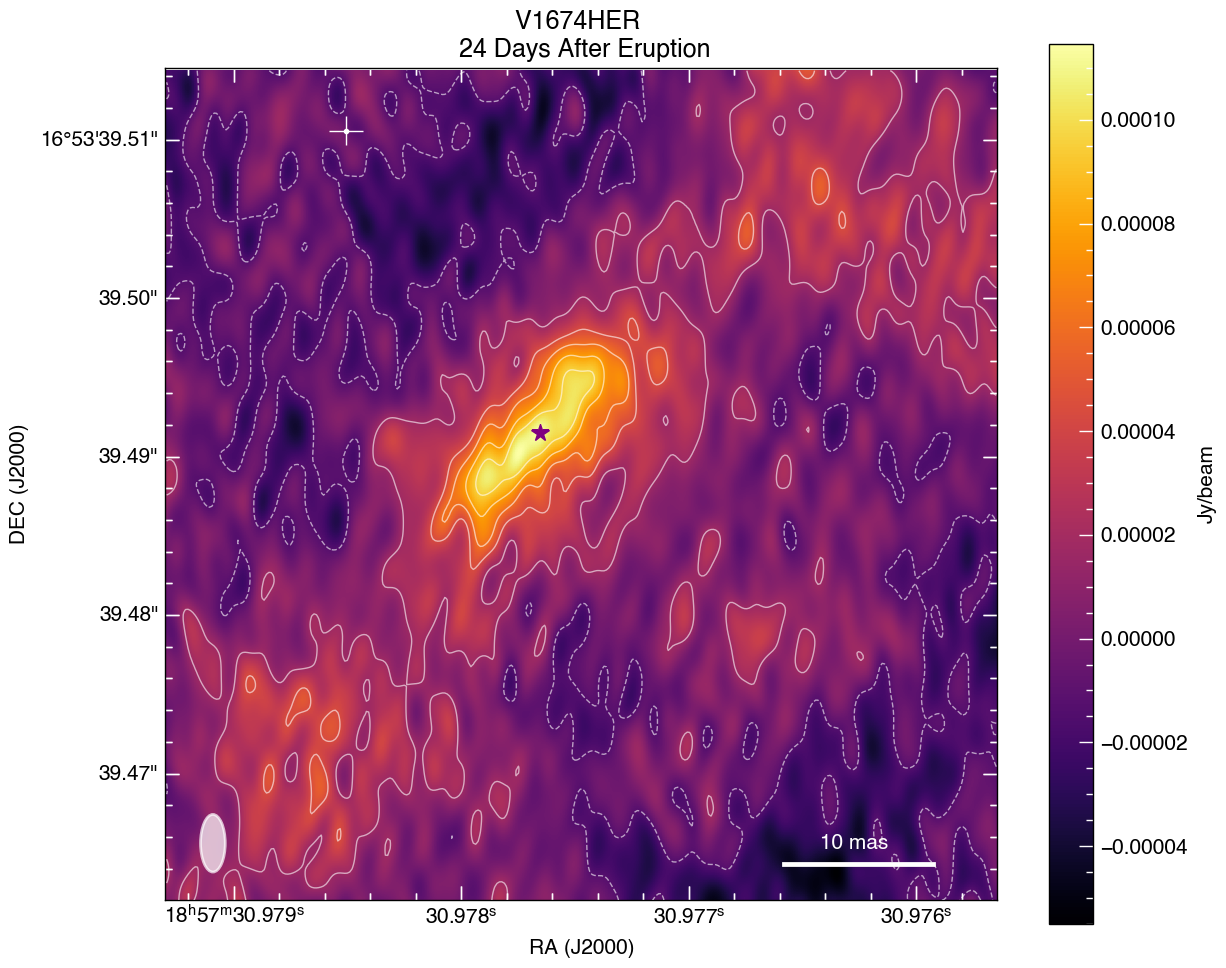

In [9]:
plt.style.use('light');

figd = plt.figure(figsize=(13,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
ra_d = axd.coords[0];
dec_d = axd.coords[1];


axd.set_title(f'V1674HER \n 24 Days After Eruption');

imgb = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutd_center, beamd, 10, axd);
beamb_patch = beam_plotter(beamd, cutd_center, axd);


cbar_d = figd.colorbar(imgb); 
cbar_d.ax.set_ylabel('Jy/beam'); 

ra_d.set_axislabel('RA (J2000)');
dec_d.set_axislabel('DEC (J2000)');

ra_d.set_ticklabel('black'); #required
dec_d.set_ticklabel('black');

axd.add_patch(beamb_patch);
axd.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgd_info['rms']*contour_levels_array;
axd.contour(cutd_data, levels=contour_levels ,transform=axd.get_transform(cut_wcsd), colors='w', alpha=0.6);

axd.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w');

axd.plot(modelfitd_coords.ra.degree, modelfitd_coords.dec.degree, transform=axd.get_transform('fk5'),
         markersize=13, color='purple', marker='*');

axd.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', 
             marker='.', transform=axd.get_transform('fk5'));

### V1674HERF

In [10]:
imgf_data, wcsf, imagef = load('./V1674HERIMG/0130/V1674HERF_CLN.fits');

imgf_info, imgf_cnt = info(imagef);

beamf = beam(imagef);

cutf_data, cut_wcsf, cutf_hdu, cutf_center = cut(imgf_data, wcsf, imagef, imgf_cnt, center_pos=modelfitb_coords, box=(350,350));




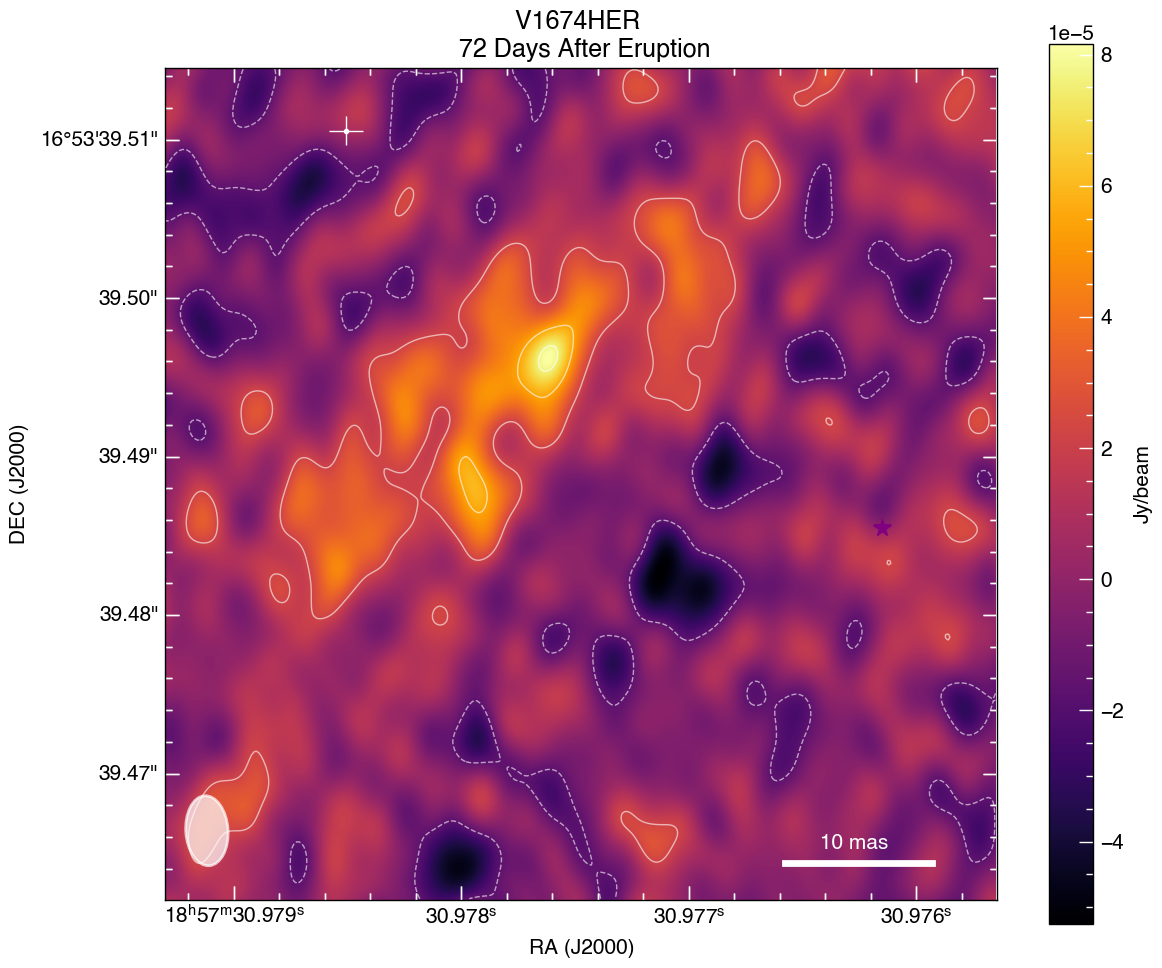

In [11]:
plt.style.use('light');

figf = plt.figure(figsize=(13,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb);
rad_f = axf.coords[0];
dec_f = axf.coords[1];


axf.set_title(f'V1674HER \n 72 Days After Eruption');

imgb = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'], 
                 transform=axf.get_transform(cut_wcsf), origin='lower');

scale_bar, sbartxt, sbar_txt_ra, sbar_txt_dec = sbar_plotter(cutf_center, beamf, 10, axf);
beamf_patch = beam_plotter(beamf, cutf_center, axf);


cbar_d = figf.colorbar(imgb); 
cbar_d.ax.set_ylabel('Jy/beam'); 

rad_f.set_axislabel('RA (J2000)');
dec_f.set_axislabel('DEC (J2000)');

rad_f.set_ticklabel('black'); #required
dec_f.set_ticklabel('black');

axf.add_patch(beamf_patch);
axf.add_patch(scale_bar);

contour_levels_array = np.array((-1.5, 2, 5, 7, 9, 11));
contour_levels = imgf_info['rms']*contour_levels_array;
axf.contour(cutf_data, levels=contour_levels ,transform=axf.get_transform(cut_wcsf), colors='w', alpha=0.6);

axf.text(sbar_txt_ra, sbar_txt_dec, sbartxt, transform=axf.get_transform('fk5'), color='w');
v1674herf_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs').transform_to(frame='fk5');
axf.plot(v1674herf_coords.ra.degree, v1674herf_coords.dec.degree, transform=axf.get_transform('fk5'),
         markersize=13, color='purple', marker='*');

axf.errorbar(shifted_gaia.ra.degree, shifted_gaia.dec.degree, yerr=gaia_yerr, xerr=gaia_xerr, color='w', 
             marker='.', transform=axf.get_transform('fk5'));

## Check & Phase Reference Source

In [12]:
# checksrcb, checksrcb_coords = difmap_model_read('./check/fitb.txt');
checkb_coords = SkyCoord('19:04:46.2574282526', '16:03:15.0463412082', unit=(un.hourangle, un.deg));
checkd_coords = SkyCoord('19:04:46.2574099526','16:03:15.0463069188', unit=(un.hourangle, un.deg));
checkf_coords = SkyCoord('19:04:46.2574062314','16:03:15.0463550053', unit=(un.hourangle, un.deg));
checkf_coords_icrs = SkyCoord('19:04:46.254662979', '16:03:15.0221210724', unit=(un.hourangle, un.deg), frame='icrs');
v1674herb_coords = SkyCoord('18:57:30.9747036153', '16:53:39.4639746068', unit=(un.hourangle, un.deg), frame='icrs');



checksched_coords = SkyCoord('19:04:46.2573', '+16:03:15.046', unit=(un.hourangle, un.degree)); #1902+159
prsched_coords = SkyCoord('18:57:25.5956', '+16:24:55.841', unit=(un.hourangle, un.degree)); #1855+163
ffsched_coords = SkyCoord('17:51:32.8186', '+09:39:00.728', unit=(un.hourangle, un.deg)); #1749+096
v1674her_sched = SkyCoord('18:57:30.979', '+16:53:39.54', unit=(un.hourangle, un.deg));

checkcal_coords = SkyCoord('19:04:46.25735000', '+16:03:15.0459200', unit=(un.hourangle, un.deg)); #RFC
prcal_coords = SkyCoord(' 18:57:25.59555586 ', '+16:24:55.8404388', unit=(un.hourangle, un.degree));


In [13]:
sep_bd = (checkb_coords.separation(checkd_coords));
sep_df = (checkf_coords.separation(checkd_coords));
sep_bf = (checkb_coords.separation(checkf_coords));

sep_schedcal = (checksched_coords.separation(checkcal_coords)).to(un.mas);
sep_schedb = (checksched_coords.separation(checkb_coords)).to(un.mas);


print(sep_bd, sep_df, sep_bf);
print(sep_schedcal, sep_schedb);
print(checksched_coords.separation(checkf_coords_icrs).to(un.mas));
print(shifted_gaia.separation(v1674her_sched).to(un.mas));

0d00m00.00026601s 0d00m00.00007204s 0d00m00.00031774s
0.725177 mas 1.87999 mas
44.8906 mas
58.0847 mas


In [14]:
dist = (6.3e3)*un.pc
dis_per = 3.8e3*un.pc;
dis_ner = 2.8e3*un.pc;

D = np.tan(sep_bd.to(un.arcsec))*dist;
print(D.to(un.AU))

1.6758872924788872 AU


In [15]:
carta_icrs = SkyCoord('18:57:25.5928698300', '+16:24:55.8164494212', unit=(un.hourangle, un.deg), frame='icrs');
RCF_icrs = SkyCoord('18:57:25.59555586', '+16:24:55.8404388', unit=(un.hourangle, un.degree), frame='icrs');

diff = carta_icrs.separation(RCF_icrs).to(un.mas);
img_diff = shifted_gaia.separation(modelfitb_coords).to(un.mas);
print(diff, img_diff);

45.4881 mas 26.844 mas
